In [1]:
# loading in and transforming data
import os
import torch
import torchvision
from torch.autograd import Variable

# Visualizing data
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Import a testframe:

In [2]:
import imageio
from imageio import get_reader

In [3]:
mov = get_reader('./data/targets/1D02F690.tif')

In [4]:
frame = []
for i, item in enumerate(mov):
    frame.append(item[:,:,0])
frame = np.array([frame])
_,_, r, c = frame.shape
frame = frame[:,:,:int(r/3),:int(c/3)].astype('d')
print(frame.shape)

(1, 1, 256, 256)


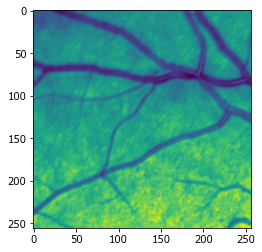

In [5]:
fig, ax = plt.subplots(1,1)
ax.cla()
ax.imshow(frame[0,0,:,:])

## Create datasets

In [6]:
import DataSet
from DataSet import RetinaDataset
from albumentations import Rotate, RandomCrop, RandomBrightnessContrast, RandomBrightness, RandomContrast, RandomSizedCrop, RandomGamma, GaussNoise, Compose, Flip, HorizontalFlip, VerticalFlip
from albumentations.pytorch import ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import RandomHorizontalFlip

In [7]:
# Transformations to apply
normalize = {'mean': 0, 'std': 1}
transforms=[ToTensor(), RandomCrop(always_apply=True, height=256, width=256)]

train_data = RetinaDataset(file_path="/data/train", transforms=transforms)
train_target = RetinaDataset(file_path="/data/targets", transforms=transforms)

## Begin modelling:

In [8]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [10]:
# residual block class
class ResidualBlock(nn.Module):
    
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2

In [11]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [12]:
# Creates transformation matrix
def transformationMatrix(dim, stride, batch_size, torch_=True):
    t = np.zeros([batch_size, dim, dim], dtype=float)
    for i in range(dim):
        if i % stride == 0:
            t[:,i,i] = 0
        else:
            t[:,i,i] = 1
    if torch_:
        t = torch.tensor(t, dtype=float, device=torch.device("cuda:0")).float()
    return t

In [13]:
def randomNoise(batch_size, shape, mu=0, sigma=1):
    r = ((torch.randn((batch_size, 1, shape, shape),device=torch.device("cuda:0"))*sigma+mu)).float()
    return r

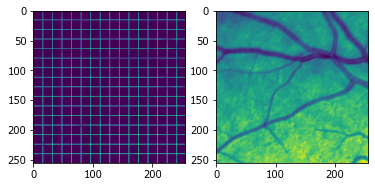

In [14]:
# Test the transformation matrix:
t_test = torch.unsqueeze(torch.tensor(transformationMatrix(256, 2**4, 1, torch_=False)), 1).numpy()
f_edit = frame-np.matmul(np.matmul(t_test, frame), t_test)
# Visualize picture:
fig, ax = plt.subplots(1,2)
ax[0].cla()
ax[0].imshow(f_edit[0,0])
ax[1].imshow(frame[0,0])

In [15]:
import cv2
def samplePics(true, output, epoch):
    path1 = os.path.join("./running_sample/true" + str(epoch) +".png")
    path2 = os.path.join("./running_sample/output" + str(epoch) + ".png")
    true = true[0,0,:,:].data.cpu().numpy()
    output = output[0,0,:,:].data.cpu().numpy()
    cv2.imwrite(path1, 255*((true)+1)/2)
    cv2.imwrite(path2, 255*((output)+1)/2)


In [16]:
os.path.join("./running_sample/true" + str(2) + ".png")

'./running_sample/true2.png'

In [17]:
class Generator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=2, t_=[]):
        super(Generator, self).__init__()
        
        # t:
        self.t = t_
        
        # 1. Define the encoder part
        # initial convolutional layer given, below
        self.conv1 = conv(1, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part of the generator
        # Residual blocks
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv3 = deconv(conv_dim, 1, kernel_size=4, batch_norm=False)
        
        # 4. Smooth the result
        #self.conv4 = conv(1, 1, kernel_size=5, stride=1, padding=2, batch_norm=False)
        
        
    def forward(self, inpt):
        # Extracts nonzero vertical and horizontal lines
        lines = inpt-torch.matmul(torch.matmul(self.t, inpt), self.t)
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        out_1 = F.relu(self.conv1(lines))
        out_2 = F.relu(self.conv2(out_1))
        out = F.relu(self.conv3(out_2))
        out = self.res_blocks(out)
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        # tanh applied to last layer
        out = torch.tanh(self.deconv3(out))
        #out = torch.tanh(self.conv4(out))
        out = lines + torch.matmul(torch.matmul(self.t, out), self.t)
        # Adds vertical and horizontal lines
        #out = lines + torch.matmul(torch.matmul(t, out), t)
        return out

In [18]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        self.conv1 = conv(1, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, inpt):
        # relu applied to all conv layers but last
        out_x = F.relu(self.conv1(inpt))
        out_x = F.relu(self.conv2(out_x))
        out_x = F.relu(self.conv3(out_x))
        out_x = F.relu(self.conv4(out_x))
        out_x = self.conv5(out_x)
        return out_x

## Create network

In [19]:

# Creates the model to be used.
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=2, ts=[]):
    """Builds the generators and discriminators."""
    
    device = torch.device("cuda:0")
    
    # Instantiate generators
    generator=Generator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks, t_=ts)
    #print("2 ", generator.t[0,0,:10,:10])
    # Instantiate discriminators
    discriminator = Discriminator(conv_dim=d_conv_dim)
    
    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        generator.to(device)
        discriminator.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return generator, discriminator



In [20]:
# Create model
stride_ = 5
batch_size= 12
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=0)
target_loader = DataLoader(dataset=train_target, batch_size=batch_size, shuffle=True, num_workers=0)
t = torch.unsqueeze(transformationMatrix(256, stride_, batch_size), 1)
generator, discriminator = create_model(n_res_blocks=4, ts=t)

Models moved to GPU.


## Optimization criteria:

In [21]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean((D_out)**2)


In [22]:
import torch.optim as optim

# hyperparams for Adam optimizer
lr_g= 0.00001
lr_d= 0.00004
beta1=0.5
beta2=0.9

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(generator.parameters(), lr_g, [beta1, beta2])
d_optimizer = optim.Adam(discriminator.parameters(), lr_d, [beta1, beta2])



## Training code:

In [23]:
# train the network
def training_loop(generator, discriminator, g_optimizer, d_optimizer, train_loader, target_loader, n_epochs=1000):
    print_every=2
    
    # keep track of losses over time
    losses = []
    rf_losses = []
    losses_test = []
    
    # Make iterators
    iter_X = iter(train_loader)
    iter_Y = iter(target_loader)
    batches_per_epoch = min(len(iter_X), len(iter_Y))
    
    c=1
    for epoch in range(1, n_epochs+1):
        print(c)
        c+=1

        # Reset iterators if left-over data does not fill a batch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(train_loader)
            iter_Y = iter(target_loader)
            print("NEXT")
        
        if epoch > 400:
            sigma = 0.001
        else:
            sigma = 0.01
        # Get batch of train and target data
        X = scale(iter_X.next()) 
        T = scale(iter_Y.next())
            
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        X = X.to(device)
        T = T.to(device)
            
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # Train with real images
        d_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        T = T# + randomNoise(batch_size=batch_size, shape=256, mu=0, sigma=sigma) # add noise
        out_T = discriminator(T)
        D_T_real_loss = real_mse_loss(out_T)
        
        # Train with fake images
        # 2. Generate fake images that look like domain X based on real images in domain Y
        T_fake = generator(X)
        
        # 3. Compute the fake loss for D_X
        T_fake = T_fake# + randomNoise(batch_size=batch_size, shape=256, mu=0, sigma=sigma) # add noise
        out_T_fake = discriminator(T_fake)
        D_T_fake_loss = fake_mse_loss(out_T_fake)
        
        # 4. Compute the total loss and perform backprop
        d_x_loss = D_T_real_loss + D_T_fake_loss
        
        # If less good at recognizing fakes than recognizing reals.
        #if (1-D_T_fake_loss)*0.1 < D_T_real_loss or epoch < 100:
        d_x_loss.backward()
        d_optimizer.step()
        #    print("train disc")
        #else:
        #    print("don't train disc")
    
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
    
        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()
    
        # 1. Generate fake images that look like domain X based on real images in domain Y
        T_fake = generator(X)

        # 2. Compute the generator loss based on domain X
        T_fake = T_fake# + randomNoise(batch_size=batch_size, shape=256, mu=0, sigma=sigma) # add noise
        out_T_fake = discriminator(T_fake)
        g_T_real_loss = real_mse_loss(out_T_fake) + torch.nn.MSELoss()(T_fake, X)

        # 3. Preform backprop:
        g_T_real_loss.backward()
        g_optimizer.step()


        # Logging info
        if epoch % print_every == 0:
            print("Train loss: ")
            print("Discriminator: ", str(d_x_loss))
            print("Generator: ", str(g_T_real_loss))
                
            losses.append((d_x_loss.item(), g_T_real_loss.item()))
            rf_losses.append((D_T_real_loss.item(), D_T_fake_loss.item()))
            
            #print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
            #        epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            samplePics(X, T_fake, epoch)

            #checkpoint_every=1000
            # Save the model parameters
            #if epoch % checkpoint_every == 0 or epoch == 1:
            #    checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='checkpoints_cyclegan_run_fulldata')

    return losses, rf_losses


In [24]:
# train the network
def training_loop_alt(generator, discriminator, g_optimizer, d_optimizer, train_loader, target_loader, n_epochs=1000):
    print_every=2
    
    # keep track of losses over time
    losses = []
    rf_losses = []
    losses_test = []
    
    # Make iterators
    iter_X = iter(train_loader)
    batches_per_epoch = len(iter_X)
    
    c=1
    for epoch in range(1, n_epochs+1):
        print(c)
        c+=1

        # Reset iterators if left-over data does not fill a batch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(train_loader)
        
        # Get batch of train and target data
        X = scale(iter_X.next()) 
            
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        X = X.to(device)
    
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
    
        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()
    
        # 1. Generate fake images that look like domain X based on real images in domain Y
        T_fake = generator(X)

        # 2. Compute the generator loss based on domain X
        g_T_real_loss = torch.nn.MSELoss()(T_fake, X)

        # 3. Preform backprop:
        g_T_real_loss.backward()
        g_optimizer.step()


        # Logging info
        if epoch % print_every == 0:
            print("Train loss: ")
            print("Generator: ", str(g_T_real_loss))
                
            losses.append(g_T_real_loss.item())
                
            #print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
            #        epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            #sample_every=100
            # Save the generated samples
            #if epoch % sample_every == 0:
            #    G_YtoX.eval()
            #    G_XtoY.eval()
            #    save_samples(epoch, fixed_Y, fixed_labels_Y, fixed_X, fixed_labels_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples_cyclegan_run_fulldata')
            #    G_YtoX.train()
            #    G_XtoY.train()

            #checkpoint_every=1000
            # Save the model parameters
            #if epoch % checkpoint_every == 0 or epoch == 1:
            #    checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='checkpoints_cyclegan_run_fulldata')

    return losses, rf_losses


In [25]:
# Train model:
n_epochs = 2000
losses, rf_losses = training_loop(generator, discriminator,g_optimizer=g_optimizer, d_optimizer=d_optimizer, train_loader=train_loader, target_loader=target_loader, n_epochs=n_epochs)

1
2
Train loss: 
Discriminator:  tensor(0.9093, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9294, device='cuda:0', grad_fn=<AddBackward0>)
3
4
Train loss: 
Discriminator:  tensor(0.6365, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.7060, device='cuda:0', grad_fn=<AddBackward0>)
5
NEXT
6
Train loss: 
Discriminator:  tensor(0.5714, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.7071, device='cuda:0', grad_fn=<AddBackward0>)
7
8
Train loss: 
Discriminator:  tensor(0.4896, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.7642, device='cuda:0', grad_fn=<AddBackward0>)
9
10
NEXT
Train loss: 
Discriminator:  tensor(0.4575, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.7823, device='cuda:0', grad_fn=<AddBackward0>)
11
12
Train loss: 
Discriminator:  tensor(0.4045, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.8390, device='cuda:0', grad_fn=<AddBackward0>)
13
14
Train loss: 
Discriminator:  tensor(0.4

104
Train loss: 
Discriminator:  tensor(0.1996, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0095, device='cuda:0', grad_fn=<AddBackward0>)
105
NEXT
106
Train loss: 
Discriminator:  tensor(0.1094, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.8681, device='cuda:0', grad_fn=<AddBackward0>)
107
108
Train loss: 
Discriminator:  tensor(0.1948, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0779, device='cuda:0', grad_fn=<AddBackward0>)
109
110
NEXT
Train loss: 
Discriminator:  tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.7861, device='cuda:0', grad_fn=<AddBackward0>)
111
112
Train loss: 
Discriminator:  tensor(0.1207, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9632, device='cuda:0', grad_fn=<AddBackward0>)
113
114
Train loss: 
Discriminator:  tensor(0.0829, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9623, device='cuda:0', grad_fn=<AddBackward0>)
115
NEXT
116
Train loss: 
Di

206
Train loss: 
Discriminator:  tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9574, device='cuda:0', grad_fn=<AddBackward0>)
207
208
Train loss: 
Discriminator:  tensor(0.0481, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0268, device='cuda:0', grad_fn=<AddBackward0>)
209
210
NEXT
Train loss: 
Discriminator:  tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.1110, device='cuda:0', grad_fn=<AddBackward0>)
211
212
Train loss: 
Discriminator:  tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9900, device='cuda:0', grad_fn=<AddBackward0>)
213
214
Train loss: 
Discriminator:  tensor(0.0529, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9176, device='cuda:0', grad_fn=<AddBackward0>)
215
NEXT
216
Train loss: 
Discriminator:  tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.1174, device='cuda:0', grad_fn=<AddBackward0>)
217
218
Train loss: 
Discrim

308
Train loss: 
Discriminator:  tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.1121, device='cuda:0', grad_fn=<AddBackward0>)
309
310
NEXT
Train loss: 
Discriminator:  tensor(0.0716, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0306, device='cuda:0', grad_fn=<AddBackward0>)
311
312
Train loss: 
Discriminator:  tensor(0.0349, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.8968, device='cuda:0', grad_fn=<AddBackward0>)
313
314
Train loss: 
Discriminator:  tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9895, device='cuda:0', grad_fn=<AddBackward0>)
315
NEXT
316
Train loss: 
Discriminator:  tensor(0.0249, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9856, device='cuda:0', grad_fn=<AddBackward0>)
317
318
Train loss: 
Discriminator:  tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0195, device='cuda:0', grad_fn=<AddBackward0>)
319
320
NEXT
Train loss: 
Di

410
NEXT
Train loss: 
Discriminator:  tensor(0.0189, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0088, device='cuda:0', grad_fn=<AddBackward0>)
411
412
Train loss: 
Discriminator:  tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.2097, device='cuda:0', grad_fn=<AddBackward0>)
413
414
Train loss: 
Discriminator:  tensor(0.0347, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.1200, device='cuda:0', grad_fn=<AddBackward0>)
415
NEXT
416
Train loss: 
Discriminator:  tensor(0.0327, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9842, device='cuda:0', grad_fn=<AddBackward0>)
417
418
Train loss: 
Discriminator:  tensor(0.0573, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.2476, device='cuda:0', grad_fn=<AddBackward0>)
419
420
NEXT
Train loss: 
Discriminator:  tensor(0.0472, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.8326, device='cuda:0', grad_fn=<AddBackward0>)
421
422
Train loss: 
Di

512
Train loss: 
Discriminator:  tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9995, device='cuda:0', grad_fn=<AddBackward0>)
513
514
Train loss: 
Discriminator:  tensor(0.0728, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.7522, device='cuda:0', grad_fn=<AddBackward0>)
515
NEXT
516
Train loss: 
Discriminator:  tensor(0.0637, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0176, device='cuda:0', grad_fn=<AddBackward0>)
517
518
Train loss: 
Discriminator:  tensor(0.0717, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0248, device='cuda:0', grad_fn=<AddBackward0>)
519
520
NEXT
Train loss: 
Discriminator:  tensor(0.0310, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.8743, device='cuda:0', grad_fn=<AddBackward0>)
521
522
Train loss: 
Discriminator:  tensor(0.0434, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0157, device='cuda:0', grad_fn=<AddBackward0>)
523
524
Train loss: 
Discrim

614
Train loss: 
Discriminator:  tensor(0.0450, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9959, device='cuda:0', grad_fn=<AddBackward0>)
615
NEXT
616
Train loss: 
Discriminator:  tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9330, device='cuda:0', grad_fn=<AddBackward0>)
617
618
Train loss: 
Discriminator:  tensor(0.0410, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9046, device='cuda:0', grad_fn=<AddBackward0>)
619
620
NEXT
Train loss: 
Discriminator:  tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0794, device='cuda:0', grad_fn=<AddBackward0>)
621
622
Train loss: 
Discriminator:  tensor(0.0297, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9050, device='cuda:0', grad_fn=<AddBackward0>)
623
624
Train loss: 
Discriminator:  tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.1266, device='cuda:0', grad_fn=<AddBackward0>)
625
NEXT
626
Train loss: 
Di

716
Train loss: 
Discriminator:  tensor(0.0337, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.2103, device='cuda:0', grad_fn=<AddBackward0>)
717
718
Train loss: 
Discriminator:  tensor(0.0250, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9895, device='cuda:0', grad_fn=<AddBackward0>)
719
720
NEXT
Train loss: 
Discriminator:  tensor(0.0259, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0842, device='cuda:0', grad_fn=<AddBackward0>)
721
722
Train loss: 
Discriminator:  tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.6780, device='cuda:0', grad_fn=<AddBackward0>)
723
724
Train loss: 
Discriminator:  tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0739, device='cuda:0', grad_fn=<AddBackward0>)
725
NEXT
726
Train loss: 
Discriminator:  tensor(0.0464, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.1288, device='cuda:0', grad_fn=<AddBackward0>)
727
728
Train loss: 
Discrim

818
Train loss: 
Discriminator:  tensor(0.0197, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9732, device='cuda:0', grad_fn=<AddBackward0>)
819
820
NEXT
Train loss: 
Discriminator:  tensor(0.0131, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0657, device='cuda:0', grad_fn=<AddBackward0>)
821
822
Train loss: 
Discriminator:  tensor(0.0202, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0085, device='cuda:0', grad_fn=<AddBackward0>)
823
824
Train loss: 
Discriminator:  tensor(0.0271, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0086, device='cuda:0', grad_fn=<AddBackward0>)
825
NEXT
826
Train loss: 
Discriminator:  tensor(0.0759, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0680, device='cuda:0', grad_fn=<AddBackward0>)
827
828
Train loss: 
Discriminator:  tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.8805, device='cuda:0', grad_fn=<AddBackward0>)
829
830
NEXT
Train loss: 
Di

920
NEXT
Train loss: 
Discriminator:  tensor(0.0345, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.1892, device='cuda:0', grad_fn=<AddBackward0>)
921
922
Train loss: 
Discriminator:  tensor(0.0343, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0394, device='cuda:0', grad_fn=<AddBackward0>)
923
924
Train loss: 
Discriminator:  tensor(0.0462, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.1508, device='cuda:0', grad_fn=<AddBackward0>)
925
NEXT
926
Train loss: 
Discriminator:  tensor(0.0198, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0205, device='cuda:0', grad_fn=<AddBackward0>)
927
928
Train loss: 
Discriminator:  tensor(0.0318, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0425, device='cuda:0', grad_fn=<AddBackward0>)
929
930
NEXT
Train loss: 
Discriminator:  tensor(0.0687, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0811, device='cuda:0', grad_fn=<AddBackward0>)
931
932
Train loss: 
Di

Discriminator:  tensor(0.0205, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.8457, device='cuda:0', grad_fn=<AddBackward0>)
1021
1022
Train loss: 
Discriminator:  tensor(0.0415, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9250, device='cuda:0', grad_fn=<AddBackward0>)
1023
1024
Train loss: 
Discriminator:  tensor(0.0265, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.1723, device='cuda:0', grad_fn=<AddBackward0>)
1025
NEXT
1026
Train loss: 
Discriminator:  tensor(0.0706, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9178, device='cuda:0', grad_fn=<AddBackward0>)
1027
1028
Train loss: 
Discriminator:  tensor(0.0143, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9104, device='cuda:0', grad_fn=<AddBackward0>)
1029
1030
NEXT
Train loss: 
Discriminator:  tensor(0.0126, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.1896, device='cuda:0', grad_fn=<AddBackward0>)
1031
1032
Train loss: 
Discriminato

1120
NEXT
Train loss: 
Discriminator:  tensor(0.0133, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9600, device='cuda:0', grad_fn=<AddBackward0>)
1121
1122
Train loss: 
Discriminator:  tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9777, device='cuda:0', grad_fn=<AddBackward0>)
1123
1124
Train loss: 
Discriminator:  tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.7645, device='cuda:0', grad_fn=<AddBackward0>)
1125
NEXT
1126
Train loss: 
Discriminator:  tensor(0.1658, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.7933, device='cuda:0', grad_fn=<AddBackward0>)
1127
1128
Train loss: 
Discriminator:  tensor(0.0316, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0179, device='cuda:0', grad_fn=<AddBackward0>)
1129
1130
NEXT
Train loss: 
Discriminator:  tensor(0.0220, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0422, device='cuda:0', grad_fn=<AddBackward0>)
1131
1132
Tr

1220
NEXT
Train loss: 
Discriminator:  tensor(0.0285, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0873, device='cuda:0', grad_fn=<AddBackward0>)
1221
1222
Train loss: 
Discriminator:  tensor(0.0187, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9156, device='cuda:0', grad_fn=<AddBackward0>)
1223
1224
Train loss: 
Discriminator:  tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0551, device='cuda:0', grad_fn=<AddBackward0>)
1225
NEXT
1226
Train loss: 
Discriminator:  tensor(0.0123, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0157, device='cuda:0', grad_fn=<AddBackward0>)
1227
1228
Train loss: 
Discriminator:  tensor(0.0148, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9513, device='cuda:0', grad_fn=<AddBackward0>)
1229
1230
NEXT
Train loss: 
Discriminator:  tensor(0.0353, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.8207, device='cuda:0', grad_fn=<AddBackward0>)
1231
1232
Tr

1320
NEXT
Train loss: 
Discriminator:  tensor(0.0194, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0512, device='cuda:0', grad_fn=<AddBackward0>)
1321
1322
Train loss: 
Discriminator:  tensor(0.0144, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9773, device='cuda:0', grad_fn=<AddBackward0>)
1323
1324
Train loss: 
Discriminator:  tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.8142, device='cuda:0', grad_fn=<AddBackward0>)
1325
NEXT
1326
Train loss: 
Discriminator:  tensor(0.0454, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.7890, device='cuda:0', grad_fn=<AddBackward0>)
1327
1328
Train loss: 
Discriminator:  tensor(0.0193, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9764, device='cuda:0', grad_fn=<AddBackward0>)
1329
1330
NEXT
Train loss: 
Discriminator:  tensor(0.0142, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0014, device='cuda:0', grad_fn=<AddBackward0>)
1331
1332
Tr

1420
NEXT
Train loss: 
Discriminator:  tensor(0.0189, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9952, device='cuda:0', grad_fn=<AddBackward0>)
1421
1422
Train loss: 
Discriminator:  tensor(0.0135, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9635, device='cuda:0', grad_fn=<AddBackward0>)
1423
1424
Train loss: 
Discriminator:  tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.8104, device='cuda:0', grad_fn=<AddBackward0>)
1425
NEXT
1426
Train loss: 
Discriminator:  tensor(0.0200, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0269, device='cuda:0', grad_fn=<AddBackward0>)
1427
1428
Train loss: 
Discriminator:  tensor(0.0173, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0107, device='cuda:0', grad_fn=<AddBackward0>)
1429
1430
NEXT
Train loss: 
Discriminator:  tensor(0.0533, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0062, device='cuda:0', grad_fn=<AddBackward0>)
1431
1432
Tr

1520
NEXT
Train loss: 
Discriminator:  tensor(0.0161, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0563, device='cuda:0', grad_fn=<AddBackward0>)
1521
1522
Train loss: 
Discriminator:  tensor(0.0112, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0212, device='cuda:0', grad_fn=<AddBackward0>)
1523
1524
Train loss: 
Discriminator:  tensor(0.0249, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0023, device='cuda:0', grad_fn=<AddBackward0>)
1525
NEXT
1526
Train loss: 
Discriminator:  tensor(0.0214, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0855, device='cuda:0', grad_fn=<AddBackward0>)
1527
1528
Train loss: 
Discriminator:  tensor(0.0124, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9744, device='cuda:0', grad_fn=<AddBackward0>)
1529
1530
NEXT
Train loss: 
Discriminator:  tensor(0.0186, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.1080, device='cuda:0', grad_fn=<AddBackward0>)
1531
1532
Tr

1620
NEXT
Train loss: 
Discriminator:  tensor(0.0337, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.1084, device='cuda:0', grad_fn=<AddBackward0>)
1621
1622
Train loss: 
Discriminator:  tensor(0.0341, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0620, device='cuda:0', grad_fn=<AddBackward0>)
1623
1624
Train loss: 
Discriminator:  tensor(0.0179, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9774, device='cuda:0', grad_fn=<AddBackward0>)
1625
NEXT
1626
Train loss: 
Discriminator:  tensor(0.0290, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9722, device='cuda:0', grad_fn=<AddBackward0>)
1627
1628
Train loss: 
Discriminator:  tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0898, device='cuda:0', grad_fn=<AddBackward0>)
1629
1630
NEXT
Train loss: 
Discriminator:  tensor(0.0146, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0503, device='cuda:0', grad_fn=<AddBackward0>)
1631
1632
Tr

1720
NEXT
Train loss: 
Discriminator:  tensor(0.0159, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0694, device='cuda:0', grad_fn=<AddBackward0>)
1721
1722
Train loss: 
Discriminator:  tensor(0.0110, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0418, device='cuda:0', grad_fn=<AddBackward0>)
1723
1724
Train loss: 
Discriminator:  tensor(0.0075, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0300, device='cuda:0', grad_fn=<AddBackward0>)
1725
NEXT
1726
Train loss: 
Discriminator:  tensor(0.0147, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0282, device='cuda:0', grad_fn=<AddBackward0>)
1727
1728
Train loss: 
Discriminator:  tensor(0.0159, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9031, device='cuda:0', grad_fn=<AddBackward0>)
1729
1730
NEXT
Train loss: 
Discriminator:  tensor(0.0173, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9562, device='cuda:0', grad_fn=<AddBackward0>)
1731
1732
Tr

1820
NEXT
Train loss: 
Discriminator:  tensor(0.0130, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0116, device='cuda:0', grad_fn=<AddBackward0>)
1821
1822
Train loss: 
Discriminator:  tensor(0.0299, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.1647, device='cuda:0', grad_fn=<AddBackward0>)
1823
1824
Train loss: 
Discriminator:  tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9167, device='cuda:0', grad_fn=<AddBackward0>)
1825
NEXT
1826
Train loss: 
Discriminator:  tensor(0.0165, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0736, device='cuda:0', grad_fn=<AddBackward0>)
1827
1828
Train loss: 
Discriminator:  tensor(0.0328, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.8946, device='cuda:0', grad_fn=<AddBackward0>)
1829
1830
NEXT
Train loss: 
Discriminator:  tensor(0.0198, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0351, device='cuda:0', grad_fn=<AddBackward0>)
1831
1832
Tr

1920
NEXT
Train loss: 
Discriminator:  tensor(0.0114, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0722, device='cuda:0', grad_fn=<AddBackward0>)
1921
1922
Train loss: 
Discriminator:  tensor(0.0092, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0091, device='cuda:0', grad_fn=<AddBackward0>)
1923
1924
Train loss: 
Discriminator:  tensor(0.0139, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0333, device='cuda:0', grad_fn=<AddBackward0>)
1925
NEXT
1926
Train loss: 
Discriminator:  tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(0.9887, device='cuda:0', grad_fn=<AddBackward0>)
1927
1928
Train loss: 
Discriminator:  tensor(0.0314, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.0307, device='cuda:0', grad_fn=<AddBackward0>)
1929
1930
NEXT
Train loss: 
Discriminator:  tensor(0.0355, device='cuda:0', grad_fn=<AddBackward0>)
Generator:  tensor(1.1618, device='cuda:0', grad_fn=<AddBackward0>)
1931
1932
Tr

In [ ]:
# Train model:
n_epochs = 600
#losses = training_loop_alt(generator, discriminator, train_loader, target_loader, n_epochs=n_epochs)

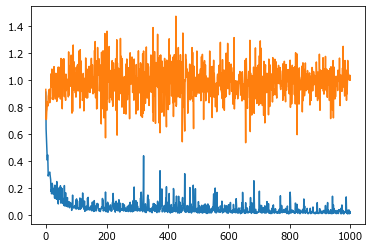

In [26]:
plt.plot(range(len(losses)), losses)

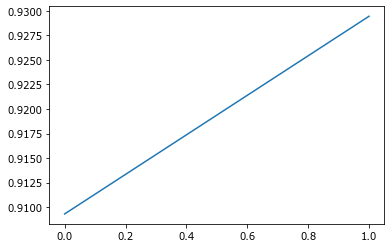

In [27]:
#plt.plot(range((len(losses[0]))), np.array(losses[0]))

## Try a test image:

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_pic = train_data[0]
train_pic = torch.unsqueeze(scale(train_pic),1).to(device)

In [29]:
generator.eval()
test_out = generator(train_pic).data.cpu().numpy()
generator.train()

Generator(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv_layer1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_layer2): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

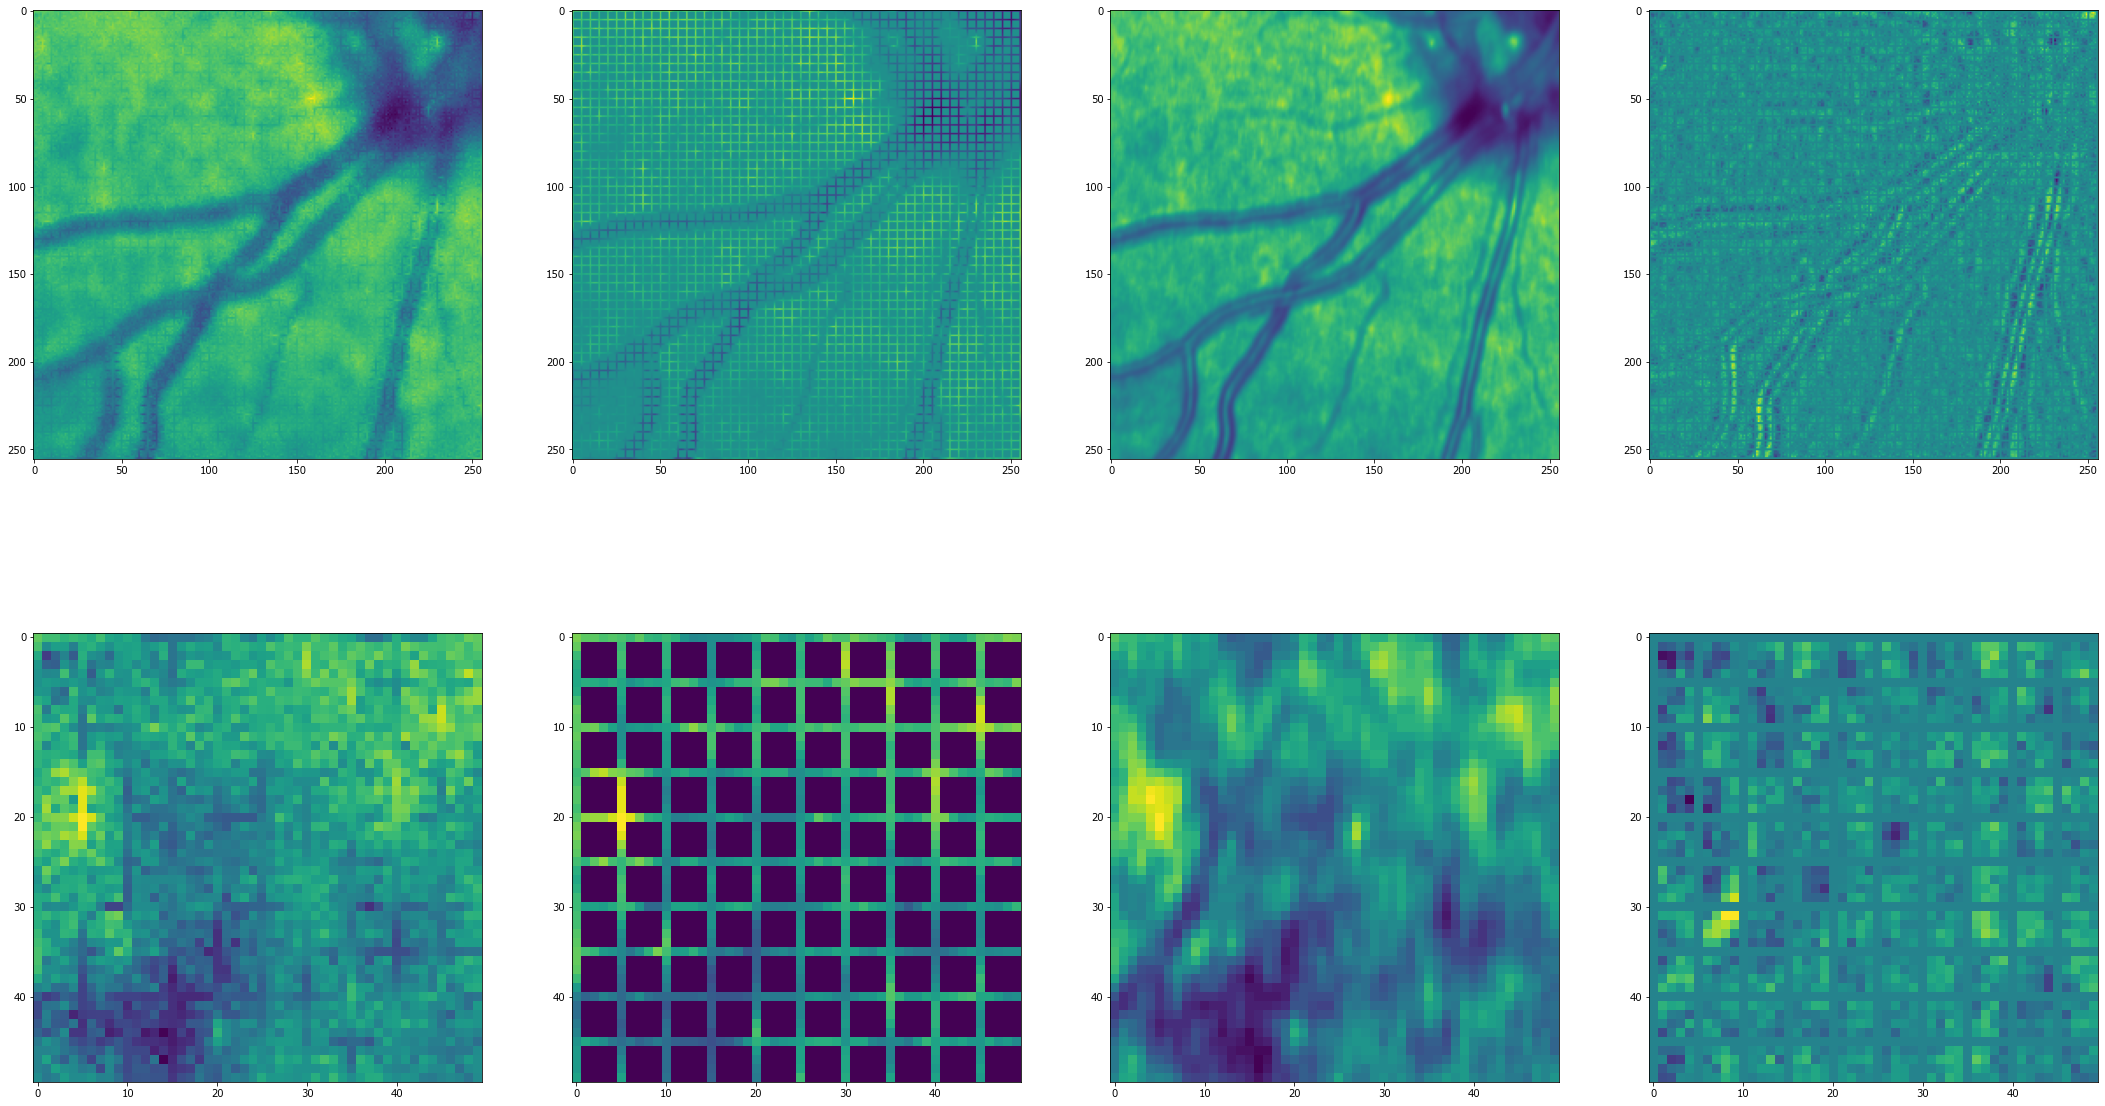

In [30]:
fig, ax = plt.subplots(2,4)
fig.set_size_inches(18.5*2, 10.5*2)
#ax.cla()
ax[0,0].imshow(test_out[0,0,:,:]) # Output
ax[0,1].imshow(train_pic.data.cpu().numpy()[0,0,:,:]-torch.matmul(t, torch.matmul(train_pic, t)).data.cpu().numpy()[0,0,:,:]) # input
ax[0,2].imshow(train_pic.data.cpu().numpy()[0,0,:,:]) # true
ax[0,3].imshow(test_out[0,0,:,:]-train_pic.data.cpu().numpy()[0,0,:,:])
ax[1,0].imshow(test_out[0,0,:50,:50]) # Output
ax[1,1].imshow(train_pic.data.cpu().numpy()[0,0,:50,:50]-torch.matmul(t, torch.matmul(train_pic, t)).data.cpu().numpy()[0,0,:50,:50]) # input
ax[1,2].imshow(train_pic.data.cpu().numpy()[0,0,:50,:50]) # true
ax[1,3].imshow(test_out[0,0,:50,:50]-train_pic.data.cpu().numpy()[0,0,:50,:50])

In [31]:
# Write samples
path = os.path.join("./samples/output.png")
cv2.imwrite(path, 255*((test_out[0,0,:,:])+1)/2)
print('Saved {}'.format(path))

# Write samples
path = os.path.join("./samples/input.png")
cv2.imwrite(path, 255*((train_pic.data.cpu().numpy()[0,0,:,:]-torch.matmul(t, torch.matmul(train_pic, t)).data.cpu().numpy()[0,0,:,:])+1)/2)
print('Saved {}'.format(path))

# Write samples
path = os.path.join("./samples/true.png")
cv2.imwrite(path, 255*((train_pic.data.cpu().numpy()[0,0,:,:])+1)/2)
print('Saved {}'.format(path))

# Write samples
path = os.path.join("./samples/diff.png")
cv2.imwrite(path, 255*((test_out[0,0,:,:]-train_pic.data.cpu().numpy()[0,0,:,:])+1)/2)
print('Saved {}'.format(path))

Saved ./samples/output.png
Saved ./samples/input.png
Saved ./samples/true.png
Saved ./samples/diff.png


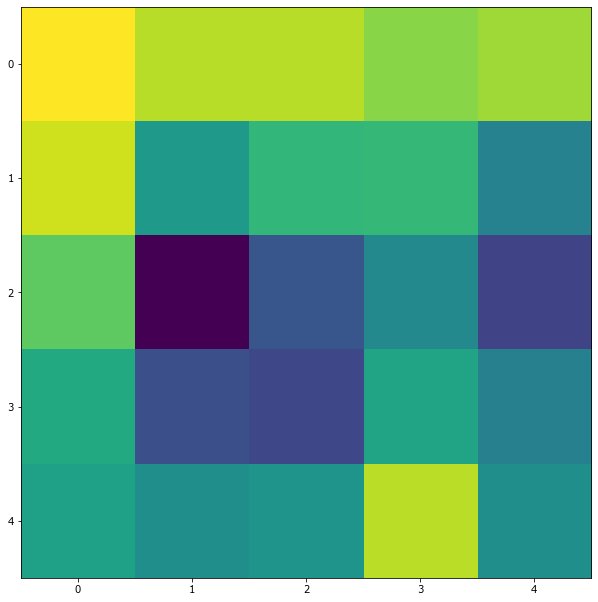

In [33]:
fig3, ax3 = plt.subplots(1,1)
fig3.set_size_inches(18.5, 10.5)
ax3.imshow((test_out[0,0,:5,:5]+1)/2) # Output

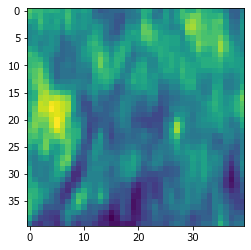

In [34]:
fig3, ax3 = plt.subplots(1,1)
#inpt-torch.matmul(torch.matmul(t, inpt), t)
ax3.imshow(train_pic.data.cpu().numpy()[0,0,:40,:40])

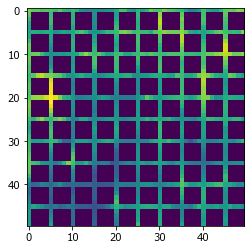

In [35]:
fig2, ax2 = plt.subplots(1,1)
ax2.imshow(train_pic.data.cpu().numpy()[0,0,:50,:50]-torch.matmul(t, torch.matmul(train_pic, t)).data.cpu().numpy()[0,0,:50,:50]) # input

## Run Tests:

In [36]:
# Create model
def runTests(name="A", n_e=100):
    strides = [2, 3, 5, 9]
    batch_size= 12
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # test frame:
    test_frame = scale(torch.tensor(frame).float()).to(device)
    for i, stride in enumerate(strides):
        train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=0)
        target_loader = DataLoader(dataset=train_target, batch_size=batch_size, shuffle=True, num_workers=0)
        t = torch.unsqueeze(transformationMatrix(256, stride, batch_size), 1)
        
        # create model
        generator, discriminator = create_model(n_res_blocks=4, ts=t)
        
        # Create optimizers for the generators and discriminators
        g_optimizer = optim.Adam(generator.parameters(), lr_g, [beta1, beta2])
        d_optimizer = optim.Adam(discriminator.parameters(), lr_d, [beta1, beta2])
        
        # Train model:
        losses, rf_losses = training_loop(generator, discriminator, g_optimizer, d_optimizer, train_loader, target_loader, n_epochs=n_e)
        
        # Evaluate test image:
        generator.eval()
        test_out = generator(test_frame).data.cpu().numpy()[0,0,:,:]
        generator.train()
        
        t_f = test_frame.data.cpu().numpy()[0,0,:,:]
        t_ = t.data.cpu().numpy()[0,0,:,:]
        # Write sample
        if True:
            path = os.path.join("./strided_pics_conv/"+name+"_output_"+str(stride-1)+"_.png")
            cv2.imwrite(path, 255*((test_out)+1)/2)
            print('Saved {}'.format(path))

            # Write sample
            path = os.path.join("./strided_pics_conv/"+name+"_input_"+str(stride-1)+"_.png")
            cv2.imwrite(path, 255*((t_f-np.matmul(t_, np.matmul(t_f, t_)))+1)/2)
            print('Saved {}'.format(path))

            # Write sample
            path = os.path.join("./strided_pics_conv/"+name+"_true_"+str(stride-1)+"_.png")
            cv2.imwrite(path, 255*((t_f)+1)/2)
            print('Saved {}'.format(path))

            # Write sample
            path = os.path.join("./strided_pics_conv/"+name+"_diff_"+str(stride-1)+"_.png")
            cv2.imwrite(path, 255*((test_out-t_f)+1)/2)
            print('Saved {}'.format(path))

            ###############
            ### Zoom in ###
            ###############
            # Write sample
            path = os.path.join("./strided_pics_conv/"+name+"_output_zoom_"+str(stride-1)+"_.png")
            cv2.imwrite(path, 255*((test_out[25:75,175:225])+1)/2)
            print('Saved {}'.format(path))

            # Write sample
            path = os.path.join("./strided_pics_conv/"+name+"_input_zoom_"+str(stride-1)+"_.png")
            cv2.imwrite(path, 255*((t_f-np.matmul(t_, np.matmul(t_f, t_)))[25:75,175:225]+1)/2)
            print('Saved {}'.format(path))

            # Write sample
            path = os.path.join("./strided_pics_conv/"+name+"_true_zoom_"+str(stride-1)+"_.png")
            cv2.imwrite(path, 255*((t_f)[25:75,175:225]+1)/2)
            print('Saved {}'.format(path))

            # Write sample
            path = os.path.join("./strided_pics_conv/"+name+"_diff_zoom_"+str(stride-1)+"_.png")
            cv2.imwrite(path, 255*((test_out-t_f)[25:75,175:225]+1)/2)
            print('Saved {}'.format(path))
        
        del generator, discriminator
        
        

In [ ]:
#del generator, discriminator
#runTests("A", n_e=1000)

In [37]:
# Create model
def runTests_alt(name="B", n_e=600):
    strides = [2, 3, 5]
    batch_size= 12
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # test frame:
    test_frame = scale(torch.tensor(frame).float()).to(device)
    for i, stride in enumerate(strides):
        train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=0)
        target_loader = DataLoader(dataset=train_target, batch_size=batch_size, shuffle=True, num_workers=0)
        t = torch.unsqueeze(transformationMatrix(256, stride, batch_size), 1)
        generator, discriminator = create_model(n_res_blocks=4, ts=t)
        
        # Create optimizers for the generators and discriminators
        g_optimizer = optim.Adam(generator.parameters(), lr_g, [beta1, beta2])
        d_optimizer = optim.Adam(discriminator.parameters(), lr_d, [beta1, beta2])
        
        # Train model:
        losses, rf_losses = training_loop_alt(generator, discriminator, g_optimizer, d_optimizer, train_loader, target_loader, n_epochs=n_e)
        
        # Evaluate test image:
        generator.eval()
        test_out = generator(test_frame).data.cpu().numpy()[0,0,:,:]
        generator.train()
        
        t_f = test_frame.data.cpu().numpy()[0,0,:,:]
        t_ = t.data.cpu().numpy()[0,0,:,:]
        # Write sample
        path = os.path.join("./strided_pics_conv/"+name+"_output_"+str(stride-1)+"_.png")
        cv2.imwrite(path, 255*((test_out)+1)/2)
        print('Saved {}'.format(path))
        
        # Write sample
        path = os.path.join("./strided_pics_conv/"+name+"_input_"+str(stride-1)+"_.png")
        cv2.imwrite(path, 255*((t_f-np.matmul(t_, np.matmul(t_f, t_)))+1)/2)
        print('Saved {}'.format(path))

        # Write sample
        path = os.path.join("./strided_pics_conv/"+name+"_true_"+str(stride-1)+"_.png")
        cv2.imwrite(path, 255*((t_f)+1)/2)
        print('Saved {}'.format(path))

        # Write sample
        path = os.path.join("./strided_pics_conv/"+name+"_diff_"+str(stride-1)+"_.png")
        cv2.imwrite(path, 255*((test_out-t_f)+1)/2)
        print('Saved {}'.format(path))
        
        ###############
        ### Zoom in ###
        ###############
        # Write sample
        path = os.path.join("./strided_pics_conv/"+name+"_output_zoom_"+str(stride-1)+"_.png")
        cv2.imwrite(path, 255*((test_out[25:75,175:225])+1)/2)
        print('Saved {}'.format(path))
        
        # Write sample
        path = os.path.join("./strided_pics_conv/"+name+"_input_zoom_"+str(stride-1)+"_.png")
        cv2.imwrite(path, 255*((t_f-np.matmul(t_, np.matmul(t_f, t_)))[25:75,175:225]+1)/2)
        print('Saved {}'.format(path))

        # Write sample
        path = os.path.join("./strided_pics_conv/"+name+"_true_zoom_"+str(stride-1)+"_.png")
        cv2.imwrite(path, 255*((t_f)[25:75,175:225]+1)/2)
        print('Saved {}'.format(path))

        # Write sample
        path = os.path.join("./strided_pics_conv/"+name+"_diff_zoom_"+str(stride-1)+"_.png")
        cv2.imwrite(path, 255*((test_out-t_f)[25:75,175:225]+1)/2)
        print('Saved {}'.format(path))
        
        del generator, discriminator

In [ ]:
#del generator, discriminator
runTests_alt("B", n_e=500)

## Signal to noise ratio

In [38]:
p = ["A_diff_1_.png", "A_diff_2_.png", "A_diff_4_.png", "B_diff_1_.png", "B_diff_2_.png", "B_diff_4_.png"]

for i, name in enumerate(p):
    path = os.path.join("./strided_pics_conv/"+name)
    im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)/255
    #print(im)
    v = np.var(im)
    STNR = 1.0/v
    print(name, " ", STNR)

A_diff_1_.png   1604.4050341086295
A_diff_2_.png   1195.4805403959317
A_diff_4_.png   894.8074147733236
B_diff_1_.png   5815.952580168117
B_diff_2_.png   1166.641172113535
B_diff_4_.png   1484.2706253207518


## Bilinear stuff

In [ ]:
import numpy as np
def lin_int_grid(im):
    copy_im = np.zeros((im.shape)).astype(int)
    for j, row in enumerate(im):
        interpol_start = 0
        interpol_end = -1
        previous_pixel = 0
        for i, pixel in enumerate(row):
            if pixel != 0 and i != 0:
                if row[interpol_start] != 0:
                    interpol_end = i
                    new_seg = np.linspace(row[interpol_start], row[interpol_end], interpol_end+1-interpol_start).astype(int)
                    copy_im[j,interpol_start:interpol_end+1] = new_seg
                interpol_start = i
    return copy_im


In [ ]:
# Test the transformation matrix:
#t_test = torch.unsqueeze(torch.tensor(transformationMatrix(284, 7, 1, torch_=False)), 1).numpy()
#f_edit = frame-np.matmul(np.matmul(t_test, frame), t_test)
#f_edit = f_edit[0,0,:,:]
#f_edit[:5,:5]

In [ ]:
#plt.imshow(lin_int_grid(f_edit), cmap='gray')

In [40]:
#t_test = torch.unsqueeze(torch.tensor(transformationMatrix(384, 2, 1, torch_=False)), 1).numpy()
#f_edit = frame-np.matmul(np.matmul(t_test, frame), t_test)
import numpy as np
def lin_int_grid(im):
    copy_im = np.zeros((im.shape)).astype(int)
    for j, row in enumerate(im):
        interpol_start = 0
        interpol_end = -1
        previous_pixel = 0
        for i, pixel in enumerate(row):
            if pixel != 0 and i != 0:
                if row[interpol_start] != 0:
                    interpol_end = i
                    new_seg = np.linspace(row[interpol_start], row[interpol_end], interpol_end+1-interpol_start).astype(int)
                    copy_im[j,interpol_start:interpol_end+1] = new_seg
                interpol_start = i
    return copy_im
#int_im = (lin_int_grid(f_edit[0,0]) + np.transpose(lin_int_grid(np.transpose(f_edit[0,0]))))/2
#plt.imshow(int_im, cmap="gray")
#plt.show()
#plt.imshow(int_im/255-frame[0,0]/255, cmap="gray")
#plt.show()